<h1>Load Modules </h1>

In [1]:
from __future__ import print_function, division
from PIL import Image
import os
import random
import glob
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from torch.utils import data as D
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import time

<h1>Load image files </h1>

In [2]:
test = Image.open('/home/s1217815/scratch/inria_data/data/AerialImageDataset/test/images/sfo7.tif')
train_image = Image.open('/home/s1217815/scratch/inria_data/data/AerialImageDataset/train/images/austin20.tif')
train_binary = Image.open('/home/s1217815/scratch/inria_data/data/AerialImageDataset/train/gt/austin20.tif')

<h3>Example Image</h3>

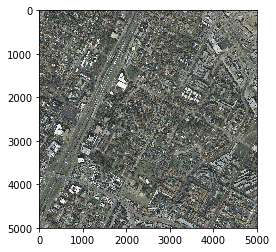

In [3]:
plt.imshow(train_image)

<h3>Example Mask</h3>

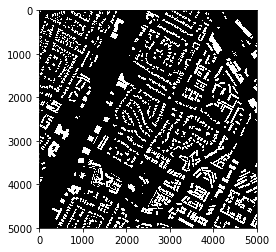

In [4]:
plt.imshow(train_binary)

<h1>CNN Architecture</h1>

<h2>Encoder</h2>

In [5]:
class SegBlockEncoder(nn.Module):
    def __init__(self,in_channel,out_channel, kernel=4,stride=2,pad=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channel,out_channel,kernel,stride=stride,padding=pad,bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(True)
            #nn.Tanh()
        )

    def forward(self, x):
        y=self.model(x)
        return y

<h2>Decoder</h2>

In [6]:
class SegBlockDecoder(nn.Module):
    def __init__(self,in_channel,out_channel, kernel=4,stride=2,pad=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channel,out_channel,kernel,stride=stride,padding=pad,bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(True)
            #nn.Tanh()
        )

    def forward(self, x):
        y=self.model(x)
        return y

<h2>Neural Network</h2>

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        cr = 8
        self.encoder = nn.Sequential(
            SegBlockEncoder(in_channel=3,out_channel=cr),
            SegBlockEncoder(in_channel=cr,out_channel=cr*2),
            SegBlockEncoder(in_channel=cr*2,out_channel=cr*4)
        )
        
        self.decoder = nn.Sequential(
            SegBlockDecoder(in_channel=cr*4, out_channel=cr*2),
            SegBlockDecoder(in_channel=cr*2,out_channel=cr),
            SegBlockDecoder(in_channel=cr, out_channel= 2)
            )
        
        self.output = nn.Softmax(dim = 1)

    def forward(self,x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        y = self.output(x2)
        #y_f = y[:,0,:,:]+y[:,1,:,:]
        return y

In [8]:
def multi_class_cross_entropy_loss_torch(predictions, labels):
    """
    Calculate multi-class cross entropy loss for every pixel in an image, for every image in a batch.

    In the implementation,
    - the first sum is over all classes,
    - the second sum is over all rows of the image,
    - the third sum is over all columns of the image
    - the last mean is over the batch of images.
    
    :param predictions: Output prediction of the neural network.
    :param labels: Correct labels.
    :return: Computed multi-class cross entropy loss.
    """

    loss = -torch.mean(torch.sum(torch.sum(torch.sum(labels * torch.log(predictions), dim=1), dim=1), dim=1))
    return loss

In [9]:
# for epoch in range(50):  # loop over the dataset multiple times

#     running_loss = 0.0
#     #for i, data in enumerate(trainloader, 0):
#         # get the inputs

#         # zero the parameter gradients
#     optimizer.zero_grad()

#         # forward + backward + optimize
#     outputs = net(train_imageCrop)
#     #print (outputs)
#     #print (ni)
#     loss = multi_class_cross_entropy_loss_torch(outputs, ni)
    
#     loss.backward()
#     optimizer.step()

#         # print statistics
#     #running_loss += loss.item()
#     #if i % 2000 == 1999:    # print every 2000 mini-batches
#     #    print('[%d, %5d] loss: %.3f' %
#     #          (epoch + 1, i + 1, running_loss / 2000))
#     #    running_loss = 0.0
#     print ('The loss after each epoch {}'.format(loss))


# print('Finished Training')
# x3= outputs.data.numpy()[0,1]
# print("x3 ndim: ", x3.ndim)
# print("x3 shape:", x3.shape)
# print("x3 size: ", x3.size)

In [16]:
class BuildingsDataset(Dataset):
    """INRIA buildings dataset"""
    
    def __init__(self,images_dir,gt_dir,train=True):
        """
        Args:
        images_dir = path to the satellite images
        gt_dir = path to the binary mask
        """
        self.image_paths = images_dir
        self.target_paths = gt_dir
        self.train=train
        
    def transform(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(5000, 5000))
        image = resize(image)
        mask = resize(mask)
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(256, 256))
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        # Transform to tensor
        image = TF.to_tensor(image)[None,:]
        #image = image.type(torch.int64) 
        mask = TF.to_tensor(mask)[None,:]
        mask = torch.cat([(mask==0).float(),(mask==1).float()],dim=1)
        return image, mask
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        mask = Image.open(self.target_paths[index])
        x, y = self.transform(image, mask)
#         print ('before dataloader dimesions of inputs: {} and labels {}'
#                 .format(x.size(), y.size()))
        return x, y

    def __len__(self):
        return len(self.image_paths)

51
<class 'torch.Tensor'> torch.Size([1, 3, 256, 256])


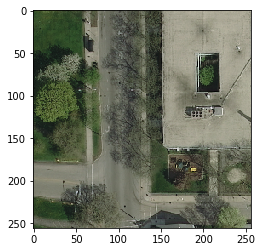

<class 'torch.Tensor'> torch.Size([1, 2, 256, 256])


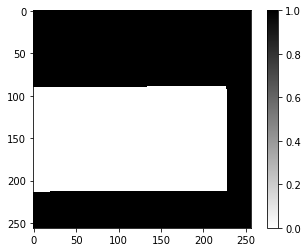

In [18]:
image_paths = glob.glob('/home/s1217815/scratch/inria_data/data/AerialImageDataset/train/images/*.tif')
target_paths = glob.glob('/home/s1217815/scratch/inria_data/data/AerialImageDataset/train/gt/*.tif')
#image_paths = glob.glob('/Volumes/s1217815/scratch/inria_data/data/AerialImageDataset/train/images/*.tif')
#target_paths = glob.glob('/Volumes/s1217815/scratch/inria_data/data/AerialImageDataset/train/gt/*.tif')
#image_paths = glob.glob('/home/s1217815/scratch/inria_data/data/inria_test/images/*.tif')
#target_paths = glob.glob('/home/s1217815/scratch/inria_data/data/inria_test/gt/*.tif')
train = BuildingsDataset(image_paths[18:], target_paths[18:])
#train = BuildingsDataset(image_paths, target_paths)
test = BuildingsDataset(image_paths[:18], target_paths[:18],train=False)
x = random.randint(0,161)
print (x)

print(type(train[x][0]), train[x][0].shape)
#for_plot = (train[x][0].permute(2,3,1,0))
plt.imshow((train[x][0].permute(2,3,1,0))[:,:,:,0])
plt.show()

print (type(train[x][1]),train[x][1].shape)
for_plot = (train[x][1].permute(2,3,1,0))
for_plot = for_plot[:,:,0:,0]
for_plot = for_plot[:,:,0]
imgplot = plt.imshow(for_plot,cmap='binary') # mask layer
plt.colorbar()
plt.show()
train_loader = DataLoader(train,batch_size=4,shuffle=True)
test_loader = DataLoader(test,batch_size=4,shuffle=True)

In [12]:
# cropper = transforms.RandomCrop(256)
# tt = ToTensor()
# train_binaryCrop = tt(train_binary.crop((0,0,256,256)))[None,:]
# #train_binaryCrop = tt(cropper(train_binary))[None,:]
# ni = torch.cat([(train_binaryCrop==0).float(),(train_binaryCrop==1).float()],dim=1)          
net = Net()
# train_imageCrop = tt(train_image.crop((0,0,256,256)))[None,:]
# #train_imageCrop = tt(cropper(train_image))[None,:]
# prediction =  net(train_imageCrop)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [19]:
# def train(epoch):
#     running_loss = 0.0
#     for i,data in enumerate (train_loader):
#         inputs, labels = data
# #         print ('before resize dimesions of inputs: {} and labels {}'
# #                 .format(inputs.size(), labels.size()))
#         inputs.resize_((4,3,256,256))
#         labels.resize_((4,2,256,256))
# #         print ('after resize dimesions of inputs: {} and labels {}'
# #         .format(inputs, labels))
#         optimizer.zero_grad()
        
#         outputs = net(inputs)
#         #loss = criterion(outputs,labels)
#         loss = multi_class_cross_entropy_loss_torch(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss =+ loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0
#         print ('The loss after each epoch {}'.format(running_loss))
# t0 = time.time()
# for i in range(150):
#     train(i)
# print('{} seconds'.format(time.time() - t0))

# print('Finished Training')

def train_(trainloader,optimizer,print_every):
    t0 = time.time()
    batches = 0
    running_loss = 0
    for inputs, labels in trainloader:
        batches += 1
        #inputs = inputs.view(-1,3,256,256)
        #labels = labels.view(-1,2,256,256)
        print (inputs.shape)
        print (labels.shape)
        #inputs.resize_((4,3,256,256))
        #labels.resize_((4,2,256,256))
        #t1 = time.time()
        #inputs, labels = inputs.to(self.device), labels.to(self.device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = multi_class_cross_entropy_loss_torch(outputs, labels)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        #print('training this batch took {:.3f} seconds'.format(time.time() - t1))
        running_loss += loss
        if batches % print_every == 0:
            print(f"{time.asctime()}.."
                    f"Time Elapsed = {time.time()-t0:.3f}.."
                    f"Batch {batches+1}/{len(trainloader)}.. "
                    f"Average Training loss: {running_loss/(batches):.3f}.. "
                    f"Batch Training loss: {loss:.3f}.. "
                    )
            t0 = time.time()
            return running_loss/len(trainloader)

for epoch in range(100):
    train_(train_loader,optimizer,1)

torch.Size([4, 1, 3, 256, 256])
torch.Size([4, 1, 2, 256, 256])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [8, 3, 4, 4], but got 5-dimensional input of size [4, 1, 3, 256, 256] instead

In [14]:
x3= outputs.data.numpy()[0,1]
plt.imshow(x3)
plt.show()

NameError: name 'outputs' is not defined

In [ ]:
def show_ds(dataset):
    print('Plotting figure')

    plt.figure(figsize=(10, 20))

    for i in range(4):
        (image, mask) = dataset[i]

        plt.tight_layout()
        plt.axis('on')

        plt.subplot(5, 5, 1 * i + 1)
        plt.imshow(image)
        plt.title("Image")

        plt.subplot(5, 5, 2 * i + 2)
        plt.imshow(mask)
        plt.title("Actual Mask")

        plt.pause(2)  # pause a bit so that plots are updated

        if i == 4:
            plt.ioff()
            plt.show()
            break

    plt.show()
    
show_ds(train)